In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from IPython.display import display
import os
import glob

In [2]:
import ee
import geemap

ee.Initialize()

In [3]:
#Station coordinates (FLATS around stations?)

stazioni = pd.read_csv('C:/Users/arj26323/Documents/Data/NERR data/All_stations2.csv')

# print(stazioni['Station Code'].unique())

stazioni = stazioni[stazioni['Station Code'].str.contains('nut')]

stazioni.rename(columns={"Latitude ": "Latitude", " Longitude": "Longitude"}, inplace= True)

dfs = stazioni[['Station Code', 'Station Name', 'Latitude', 'Longitude']].reset_index()

dfs

,index,Station Code,Station Name,Latitude,Longitude
0,0,acebbnut,Big Bay,32.49410,-80.32410
1,3,acefcnut,Fishing Creek,32.63593,-80.36556
2,5,acemcnut,Mosquito Creek,32.55580,-80.43800
3,8,acespnut,St. Pierre,32.52800,-80.36144
4,11,aceeinut,Edisto Island,32.50400,-80.32470
...,...,...,...,...,...
147,340,wkbwsnut,Weather Station,30.41481,-87.82600
148,344,wqbcrnut,Childs River,41.57980,-70.53090
149,347,wqbmhnut,Menauhant,41.55260,-70.54850
150,349,wqbmpnut,Metoxit Point,41.56890,-70.52160


In [4]:
dfx = dfs[dfs['Station Code']=='cbmrrnut  '] #two spaces put in after each code for some stupid fucking reason

# dfs.iloc[0,0]

dfx

# dfx.iloc[0,3]

,index,Station Code,Station Name,Latitude,Longitude
19,42,cbmrrnut,Railroad,38.7813,-76.7137


In [5]:
px = ee.Geometry.Point([dfx.iloc[0,4], dfx.iloc[0,3]])
#lon and lat

Map = geemap.Map(center=[38.7813,-76.7137], zoom=16)

# Map

In [ ]:
##Function to cloud mask from the pixel_qa band of Landsat 5/8 SR data.
def maskL5sr(image):
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)
    # Apply the scaling factors to the appropriate bands.
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    # Replace the original bands with the scaled ones and apply the masks.
    return image.addBands(opticalBands, None, True) \
    .addBands(thermalBands, None, True) \
    .updateMask(qaMask) \
    .updateMask(saturationMask)

def addFLATSL7(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(RED-SWIR)/(RED+SWIR) - 41.2*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1)))', {
            'SWIR': image.select('SR_B5'),
            'NIR': image.select('SR_B4'),
            'RED': image.select('SR_B3'),
            'BLUE': image.select('SR_B1')
        })
    
    return image.addBands(flats.rename('flats'))

def addFLATSL5(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(0.972*(RED-SWIR)/(RED+SWIR)-0.008) - 41.2*(0.991*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1)-0.0014)))', {
            'SWIR': image.select('SR_B5'),
            'NIR': image.select('SR_B4'),
            'RED': image.select('SR_B3'),
            'BLUE': image.select('SR_B1')
        })
    
    return image.addBands(flats.rename('flats'))


def addFLATSL8(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(0.841*(RED-SWIR)/(RED+SWIR) - 0.019) - 41.2*(0.771*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1) + 0.011)))', {
            'SWIR': image.select('SR_B6'),
            'NIR': image.select('SR_B5'),
            'RED': image.select('SR_B4'),
            'BLUE': image.select('SR_B2')
        })
    
    return image.addBands(flats.rename('flats'))

def addFLATSL9(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(1.225*(RED-SWIR)/(RED+SWIR) + 0.096) - 41.2*(1.038* (NIR-RED)/(NIR+6*RED-7.5*BLUE+1) - 0.004)))', {
            'SWIR': image.select('SR_B6'),
            'NIR': image.select('SR_B5'),
            'RED': image.select('SR_B4'),
            'BLUE': image.select('SR_B2')
        })
    
    return image.addBands(flats.rename('flats'))

def add_date_band(image):
    # Get the acquisition date
    date = ee.Date(image.get('system:time_start'))
    
    # Convert the date to milliseconds since Unix epoch
    date_millis = date.millis()
    
    # Create an image with a single band representing the acquisition date
    date_image = ee.Image.constant(date_millis).int64().rename('acquisition_date')
    
    # Add the date image as a band to the original image
    return image.addBands(date_image)

# vcr_lter = geemap.shp_to_ee('F:/Wetlands shapefiles/VCR domain/VCR_LTER_boundary.shp')

#Loading gee datasets
l8_col = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1998, 2023,'year')) \
    .filterBounds(px.buffer(10000)) \
    .map(maskL5sr).map(addFLATSL8).map(add_date_band)

l7_col = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1984, 2023,'year')) \
    .filterBounds(px.buffer(10000))\
    .map(maskL5sr).map(addFLATSL7).map(add_date_band)

l5_col = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1984, 2023,'year')) \
    .filterBounds(px.buffer(10000))\
    .map(maskL5sr).map(addFLATSL5).map(add_date_band)

l9_col = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2") \
    .filter(ee.Filter.calendarRange(1998, 2023,'year')) \
    .filterBounds(px.buffer(10000))\
    .map(maskL5sr).map(addFLATSL9).map(add_date_band)


bb = ee.Geometry.Polygon([[-81.29, 31.425], [-81.29, 31.46], [-81.27, 31.46],[-81.27, 31.425]])


In [ ]:
ultra_col = l5_col.merge(l7_col).merge(l8_col).merge(l9_col)

# ultra = ultra_col.filter(ee.Filter.calendarRange(1984, 2023,'year')).filterBounds(flux_ga)
ultra = ultra_col.filter(ee.Filter.calendarRange(2004, 2024,'year')).map(lambda image: image.clip(px)) \
    .filter(ee.Filter.lte('CLOUD_COVER_LAND', 50))

In [ ]:
def point_extract(image):
    
    feature = image.sampleRegions(
        collection=px,
        scale=30,
        geometries=True)
    
    return feature.limit(5000)

In [ ]:
im_list = ultra.toList(ultra.size())

In [ ]:
#Extract time series for nutrient station

feature_list = ultra.map(point_extract).flatten().toList(ultra.size())
values_list = []

# Loop through the feature list and extract values
for i in range(feature_list.size().getInfo()):
    feature = ee.Feature(feature_list.get(i))
    properties = feature.toDictionary()
    values_list.append(properties.getInfo())

# Convert the list of dictionaries to a pandas DataFrame
timeseries_df = pd.DataFrame(values_list)

# Print the DataFrame
print(timeseries_df)

In [ ]:
timeseries_df

In [ ]:
import os
out_dir = os.path.expanduser('C:/Users/arj26323/Documents/Data/NERR data/')
out_csv = os.path.join(out_dir, 'timeseries_VCR.csv')
# timeseries_df.to_csv(out_csv, index = False)

In [6]:
timeseries_df = pd.read_csv('C:/Users/arj26323/Documents/Data/NERR data/timeseries_VCR.csv')

In [7]:
timeseries_df['Date'] = pd.to_datetime(timeseries_df['acquisition_date'], unit = 'ms')
timeseries_df['DOY'] = timeseries_df['Date'].dt.strftime('%Y-%m-%d')
timeseries_df['DOY'] = pd.to_datetime(timeseries_df['DOY'])

timeseries_df

,QA_PIXEL,QA_RADSAT,SR_ATMOS_OPACITY,SR_B1,SR_B2,SR_B3,SR_B4,SR_B5,SR_B7,SR_CLOUD_QA,...,ST_QA,ST_TRAD,ST_URAD,acquisition_date,flats,SR_B6,SR_QA_AEROSOL,ST_B10,Date,DOY
0,5504,0,11.0,0.062020,0.092600,0.090180,0.079015,0.049865,0.024757,32.0,...,628,6000,145,1073489113391,0.995321,NaN,NaN,NaN,2004-01-07 15:25:13.391,2004-01-07
1,13600,0,12.0,0.089492,0.126645,0.121997,0.110805,0.046207,0.041560,36.0,...,633,5723,147,1074871516564,0.999346,NaN,NaN,NaN,2004-01-23 15:25:16.564,2004-01-23
2,5504,0,8.0,0.074945,0.113198,0.130247,0.091885,0.040817,0.025583,32.0,...,364,6000,169,1076253919691,0.999878,NaN,NaN,NaN,2004-02-08 15:25:19.691,2004-02-08
3,5504,0,9.0,0.042990,0.064357,0.058005,0.049095,0.055337,0.032403,32.0,...,252,6775,337,1079018731035,0.890136,NaN,NaN,NaN,2004-03-11 15:25:31.035,2004-03-11
4,5440,0,346.0,0.044393,0.067355,0.057978,0.125682,0.065320,0.039717,1.0,...,315,8547,3140,1084548419369,0.157169,NaN,NaN,NaN,2004-05-14 15:26:59.369,2004-05-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,21952,0,NaN,0.015407,0.024895,0.045520,0.046620,0.046180,0.025335,NaN,...,243,8780,1330,1694879191904,0.975981,0.041917,96.0,297.413846,2023-09-16 15:46:31.904,2023-09-16
272,21952,0,NaN,0.024345,0.030972,0.047500,0.045630,0.038288,0.021402,NaN,...,250,8568,2401,1696261591676,0.997538,0.031358,64.0,295.844975,2023-10-02 15:46:31.676,2023-10-02
273,21952,0,NaN,0.025913,0.032485,0.047747,0.047830,0.033475,0.020825,NaN,...,323,7830,1012,1697644001938,0.999516,0.027287,96.0,288.988427,2023-10-18 15:46:41.938,2023-10-18
274,21952,0,NaN,0.023712,0.029762,0.046703,0.040845,0.019175,0.016177,NaN,...,224,7433,452,1699026394403,0.999814,0.021265,96.0,284.996180,2023-11-03 15:46:34.403,2023-11-03


<Axes: xlabel='Date', ylabel='flats'>

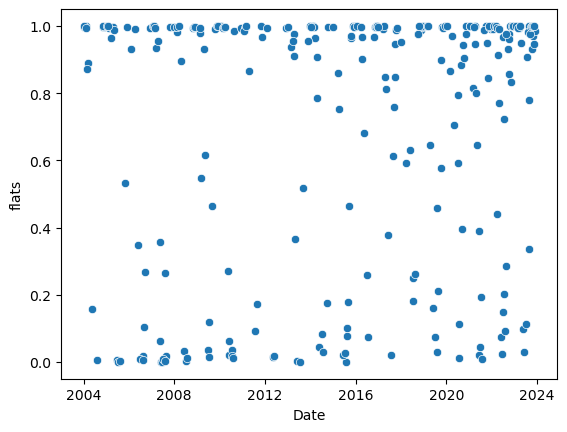

In [8]:
import seaborn as sns
sns.scatterplot(data = timeseries_df, x = 'Date', y = 'flats')

##NOTE: NUTRIENT STATION IS ON DOCK IN MIDDLE OF CREEK _ FLATS WILL NOT BE ACCURATE HERE __ NEED AREA

In [23]:
#Tides -- VA (is this close enough to where NERR station is? check tide gauge location)

path = r'C:/Users/arj26323/Documents/Data/Tide data/MD_tides_8577330_Solomons_Island_MD' 
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)

df2 = df.copy()
df2['Time (GMT)'] = pd.to_datetime(df2['Time (GMT)'])
df2['DOY'] = pd.to_datetime(df2['Date'])

time_mask = (df2['Time (GMT)'].dt.hour == 16)
va_time = df2[time_mask]

va_time['Verified (m)'] = va_time['Verified (m)'].replace('-', float('nan')).astype('float')

va_time

##Combine time/tide and flats data
df_combined = pd.merge(timeseries_df, va_time, on = 'DOY')
df_combined['Date'] = df_combined['Date_x']
df_combined

,QA_PIXEL,QA_RADSAT,SR_ATMOS_OPACITY,SR_B1,SR_B2,SR_B3,SR_B4,SR_B5,SR_B7,SR_CLOUD_QA,...,SR_QA_AEROSOL,ST_B10,Date_x,DOY,Date_y,Time (GMT),Predicted (m),Preliminary (m),Verified (m),Date
0,5504,0,11.0,0.062020,0.092600,0.090180,0.079015,0.049865,0.024757,32.0,...,NaN,NaN,2004-01-07 15:25:13.391,2004-01-07,2004/01/07,2024-05-02 16:00:00,0.104,-,-0.087,2004-01-07 15:25:13.391
1,13600,0,12.0,0.089492,0.126645,0.121997,0.110805,0.046207,0.041560,36.0,...,NaN,NaN,2004-01-23 15:25:16.564,2004-01-23,2004/01/23,2024-05-02 16:00:00,-0.062,-,-0.159,2004-01-23 15:25:16.564
2,5504,0,8.0,0.074945,0.113198,0.130247,0.091885,0.040817,0.025583,32.0,...,NaN,NaN,2004-02-08 15:25:19.691,2004-02-08,2004/02/08,2024-05-02 16:00:00,-0.056,-,-0.190,2004-02-08 15:25:19.691
3,5504,0,9.0,0.042990,0.064357,0.058005,0.049095,0.055337,0.032403,32.0,...,NaN,NaN,2004-03-11 15:25:31.035,2004-03-11,2004/03/11,2024-05-02 16:00:00,0.001,-,0.236,2004-03-11 15:25:31.035
4,5440,0,346.0,0.044393,0.067355,0.057978,0.125682,0.065320,0.039717,1.0,...,NaN,NaN,2004-05-14 15:26:59.369,2004-05-14,2004/05/14,2024-05-02 16:00:00,0.414,-,0.365,2004-05-14 15:26:59.369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,21952,0,NaN,0.015407,0.024895,0.045520,0.046620,0.046180,0.025335,NaN,...,96.0,297.413846,2023-09-16 15:46:31.904,2023-09-16,2023/09/16,2024-05-02 16:00:00,0.263,-,0.583,2023-09-16 15:46:31.904
272,21952,0,NaN,0.024345,0.030972,0.047500,0.045630,0.038288,0.021402,NaN,...,64.0,295.844975,2023-10-02 15:46:31.676,2023-10-02,2023/10/02,2024-05-02 16:00:00,0.119,-,0.419,2023-10-02 15:46:31.676
273,21952,0,NaN,0.025913,0.032485,0.047747,0.047830,0.033475,0.020825,NaN,...,96.0,288.988427,2023-10-18 15:46:41.938,2023-10-18,2023/10/18,2024-05-02 16:00:00,0.120,-,0.334,2023-10-18 15:46:41.938
274,21952,0,NaN,0.023712,0.029762,0.046703,0.040845,0.019175,0.016177,NaN,...,96.0,284.996180,2023-11-03 15:46:34.403,2023-11-03,2023/11/03,2024-05-02 16:00:00,0.113,-,0.349,2023-11-03 15:46:34.403


<Axes: xlabel='Date', ylabel='flats'>

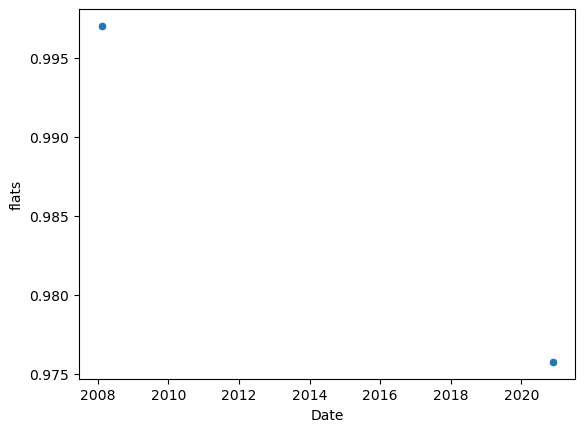

In [51]:
import seaborn as sns

dfy = df_combined[df_combined['Verified (m)'] < -0.2]

sns.scatterplot(data = dfy, x = 'Date', y = 'flats')

In [25]:
##Adding nutrient data

##CBMRR station
path = r'C:/Users/arj26323/Documents/Data/NERR data/Files 2024' #changed from Files folder 4/25/24
all_files = glob.glob(path + "/cbmrrnut*.csv")

li = []

for filename in all_files:
    df_sap = pd.read_csv(filename, index_col=None, header=0)
    li.append(df_sap)

df_sap = pd.concat(li, axis=0, ignore_index=True).dropna(subset=['NO23F']).dropna(axis=1)

##Begin:
df_sap = df_sap[df_sap['NO23F'] < 0.9] ##removes several extremely large outliers
df_sap['Date_m'] = pd.to_datetime(df_sap['DateTimeStamp'])
df_sap['DOY'] = df_sap['Date_m'].dt.strftime('%Y-%m-%d')
df_sap['DOY'] = pd.to_datetime(df_sap['DOY'])

df_sap

,StationCode,isSWMP,DateTimeStamp,Historical,ProvisionalPlus,CollMethd,REP,F_PO4F,NH4F,F_NH4F,F_NO2F,F_NO3F,NO23F,F_NO23F,F_CHLA_N,Date_m,DOY
4,cbmrrnut,P,04/29/2003 7:45,1,1,1,1,<4>,0.047,<4>,<4>,<4> C,0.871,<4>,<4>,2003-04-29 07:45:00,2003-04-29
5,cbmrrnut,P,05/06/2003 10:15,1,1,1,1,<4>,0.056,<4>,<4>,<4> C,0.834,<4>,<4>,2003-05-06 10:15:00,2003-05-06
7,cbmrrnut,P,05/20/2003 8:15,1,1,1,1,<4>,0.104,<4>,<4>,<4> C,0.761,<4>,<4>,2003-05-20 08:15:00,2003-05-20
8,cbmrrnut,P,05/28/2003 9:00,1,1,1,1,<4>,0.093,<4>,<4>,<4> C,0.559,<4>,<4>,2003-05-28 09:00:00,2003-05-28
10,cbmrrnut,P,06/10/2003 8:00,1,1,1,1,<4>,0.064,<4>,<4>,<4> C,0.798,<4>,<4>,2003-06-10 08:00:00,2003-06-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1129,cbmrrnut,P,10/19/2022 8:01,0,1,1,2,<1> (CHB),0.011,<1> (CHB),<1> (CHB),<1> (CHB),0.282,<1> (CHB),<0>,2022-10-19 08:01:00,2022-10-19
1130,cbmrrnut,P,11/17/2022 8:30,0,1,1,1,<1> (CHB),0.034,<1> (CHB),<1> (CHB),<1> (CHB),0.372,<0>,<0>,2022-11-17 08:30:00,2022-11-17
1131,cbmrrnut,P,11/17/2022 8:31,0,1,1,2,<1> (CHB),0.032,<1> (CHB),<1> (CHB),<1> (CHB),0.389,<0>,<0>,2022-11-17 08:31:00,2022-11-17
1132,cbmrrnut,P,12/06/2022 8:30,0,1,1,1,<1> (CHB),0.063,<1> (CHB),<1> (CHB),<1> (CHB),0.573,<1> (CHB),<0>,2022-12-06 08:30:00,2022-12-06


<Axes: xlabel='Date_m', ylabel='NO23F'>

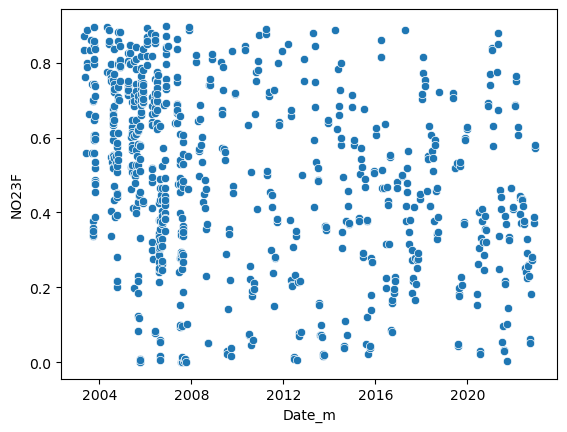

In [26]:
sns.scatterplot(data = df_sap, x = 'Date_m', y = 'NO23F')

In [27]:
##Combine nutrient data with flats and time/tide data
##Need to do merge_asof to take advantage of the large sample size for nutrient data
##Also, need to do a little pixel neighborhood, rather than a single pixel when analyzing FLATS/biomass (eventually)


# df_combined.columns = df_combined.columns.str.rstrip('_x') #remove suffix to avoid error
# df_combined2 = pd.merge(df_combined, df_sap, on = 'DOY')
# # df_combined2['Date'] = df_combined2['Date_']
# df_combined2.rename(columns={ df_combined2.columns[-1]: "Date_xxx" }, inplace = True)


##Merge, to nearest Landsat acquisition
df_combined2 = pd.merge_asof(
    df_combined.sort_values('Date'), 
    df_sap.sort_values('Date_m'), 
    left_on = 'Date',
    right_on = 'Date_m', 
    direction = 'nearest', 
    tolerance=pd.Timedelta("1210000000ms") ##Two weeks - is this ok?
)

df_combined2


,QA_PIXEL,QA_RADSAT,SR_ATMOS_OPACITY,SR_B1,SR_B2,SR_B3,SR_B4,SR_B5,SR_B7,SR_CLOUD_QA,...,F_PO4F,NH4F,F_NH4F,F_NO2F,F_NO3F,NO23F,F_NO23F,F_CHLA_N,Date_m,DOY_y
0,5504,0,11.0,0.062020,0.092600,0.090180,0.079015,0.049865,0.024757,32.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
1,5504,0,85.0,0.053522,0.077310,0.071727,0.040708,0.024207,0.003582,32.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
2,13600,0,12.0,0.089492,0.126645,0.121997,0.110805,0.046207,0.041560,36.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
3,5504,0,8.0,0.074945,0.113198,0.130247,0.091885,0.040817,0.025583,32.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
4,5504,0,8.0,0.041175,0.064357,0.052312,0.036995,0.032952,0.020330,32.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,21952,0,NaN,0.029487,0.035015,0.052175,0.050553,0.035895,0.026160,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
272,21952,0,NaN,0.023712,0.029762,0.046703,0.040845,0.019175,0.016177,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
273,21952,0,NaN,0.022585,0.030422,0.053440,0.053825,0.046648,0.025913,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
274,21952,0,NaN,0.022310,0.030587,0.047885,0.041945,0.014445,0.009907,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT


In [28]:
len(df_combined2['NO23F'].dropna())

194

<Axes: xlabel='NO23F', ylabel='flats'>

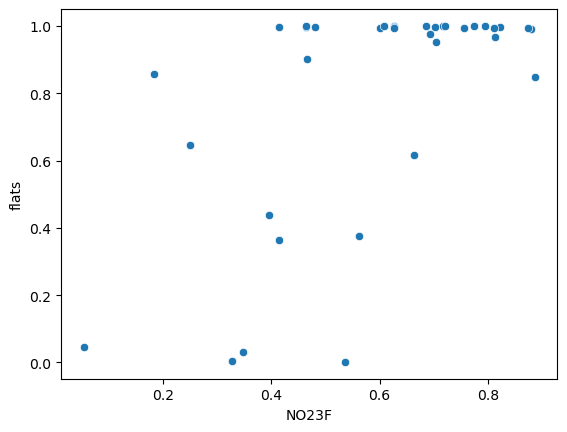

In [44]:
import seaborn as sns
import matplotlib as plt

dfz = df_combined2[df_combined2['Verified (m)'] < 0.18]

sns.scatterplot(data = dfz, x = 'NO23F', y = 'flats') ##This doesn't really tell you much. Need time + flats + N

In [43]:
print(dfz.shape)

##Tide quantiles will be different

min(dfz['Verified (m)'])

df_combined['Verified (m)'].quantile([0,.25, .5, 0.75, 1])

(267, 49)


0.00   -0.2560
0.25    0.1790
0.50    0.3170
0.75    0.4455
1.00    0.7470
Name: Verified (m), dtype: float64

0.5511120313725568
Time lagged correlation coefficient between 'NO23F' and 'flats' (lag = 1): 0.24


<Axes: xlabel='NO23F', ylabel='flats'>

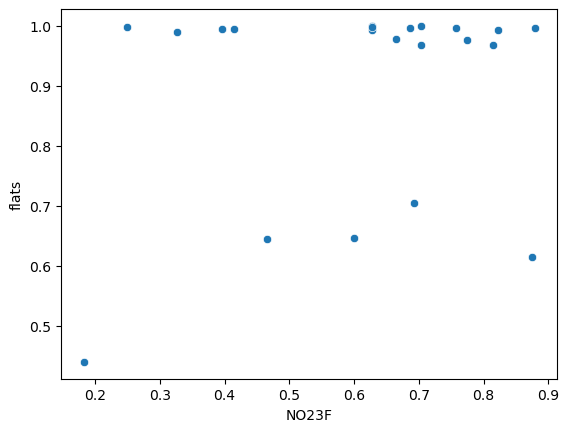

In [36]:
correlation = dfz['flats'].corr(dfz['NO23F'])
print(correlation)


##Time lag
lag = 1 #why choose this number?

no23_shifted = dfz['NO23F'].shift(-lag)

no23_shifted = no23_shifted.dropna()

# Calculate the correlation between the shifted variable and the original variable
time_lagged_corr = dfz['flats'].corr(no23_shifted)

# Print the time lagged correlation coefficient
print("Time lagged correlation coefficient between 'NO23F' and 'flats' (lag = {}): {:.2f}".format(lag, time_lagged_corr))

sns.scatterplot(x = no23_shifted, y = dfz['flats']) ##This doesn't really tell you much. Need time + flats + N

<Axes: xlabel='Date', ylabel='flats'>

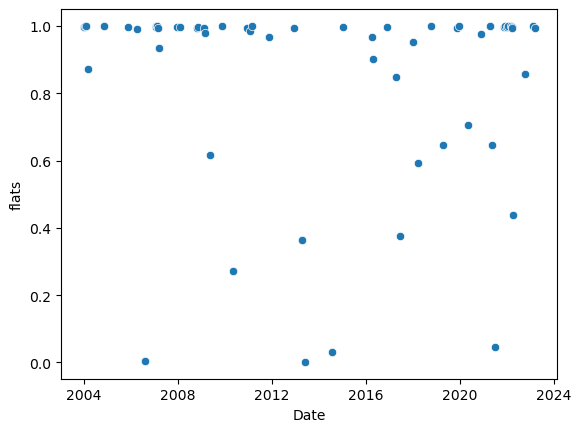

In [45]:
sns.scatterplot(data = dfz, x = 'Date', y = 'flats')

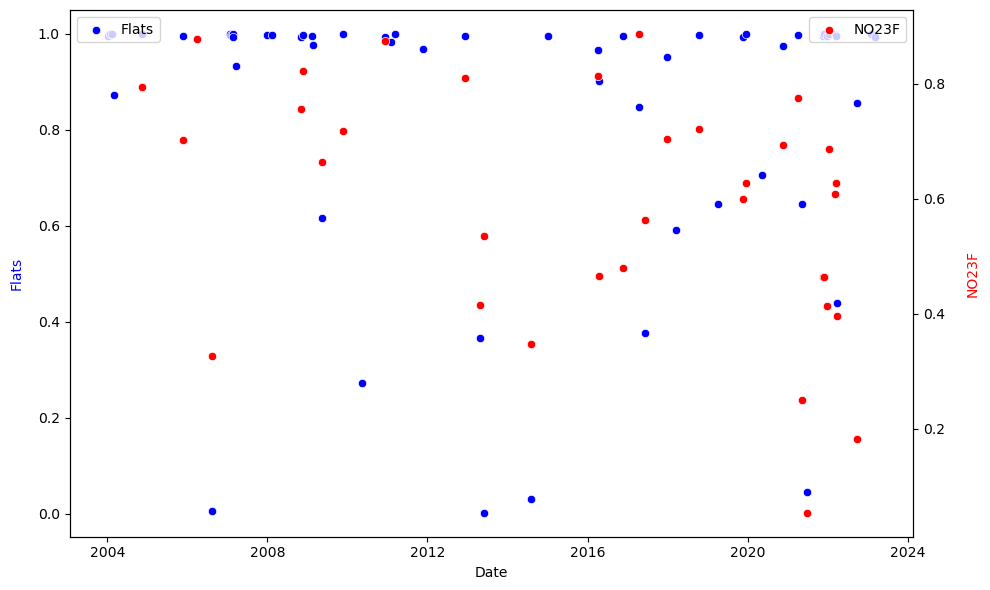

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 6))

# Primary y-axis (flats)
sns.scatterplot(ax=ax1, data=dfz, x='Date', y='flats', label='Flats', color='blue')
ax1.set_ylabel('Flats', color='blue', labelpad=10)

# Secondary y-axis (NO23F)
ax2 = ax1.twinx()  # Create a twin axis that shares the x-axis
sns.scatterplot(ax=ax2, data=dfz, x='Date', y='NO23F', label='NO23F', color='red')
ax2.set_ylabel('NO23F', color='red',  labelpad=15)

# Customize the plot further (optional)
# Place legend on primary y-axis
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc='upper left')  

# Alternatively, place legend on secondary y-axis
handles2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(handles2, labels2, loc='upper right')

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()

# Display the plot
plt.show()